The parameter space f SSMs provides a compact representation that is amenable to learning algorithms (e.g. classification or clustering), evaluation, and exploration. Some of these aspects will be explored in this part of the tutorial.

We employ shape data of 116 distal femora that where, among others, used in

[Rigid motion invariant statistical shape modeling based on discrete fundamental forms](https://doi.org/10.1016/j.media.2021.102178), F. Ambellan, S. Zachow, Christoph von Tycowicz, Medical Image Analysis (2021). [PDF](https://arxiv.org/pdf/2111.06850.pdf)

The respective segmentation masks are publicly available at [pubdata.zib.de](https://pubdata.zib.de). 

To speed up things a little bit, this part of the tutorial starts right after the model creation step, i.e. we have already constructed a shape model. We will work with the shape weights stored in `SSM.coeffs` (uniquely determining all input shapes).

The data set splits into two subgoups of the same cardinality, namely, healthy and diseased femora. In the following we want to visualize the shape weights in different ways and later use them to perform a classification experiment on osteoarthritis. 

# Visualization of Principal Weights 

## Load data

At first we load the principal weights that are stored together with the labels (healthy/diseased) in a numpy array for PDM and FCM, repsectively. At second we define unique colors to represent FCM and PDM in all subsequent plots.

In [2]:
import numpy as np
from tutorial2_pop_med_image_shape_ana.utils.sammon import sammon
from tutorial2_pop_med_image_shape_ana.utils.utils import runSVMClassification, plotClassificationResults
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

dataFCM = np.load('tutorial2_pop_med_image_shape_ana/data/femurOAclassificationDataFCM.npy')
dataPDM = np.load('tutorial2_pop_med_image_shape_ana/data/femurOAclassificationDataPDM.npy')

# first row -> label {0, 1}, second to last row -> shape weights (column is sample, row is feature)
labels = dataFCM[0, :]
fcmFeatures = dataFCM[1:, :]
pdmFeatures = dataPDM[1:, :]

# dark green (FCM) and dark violet (PDM)
colors = ['#008c04', '#ae00d8']

## Task 4 on Visualization of Two Principal Weights

At first will will focus on different pairs $\{(\alpha_i^{pw_1}, \alpha_i^{pw_2})\}$ of two weights that we can easily visualize in 2d scatter plots. We heryby assign different markers to different disease states.

Choose different values for `pw1` and `pw2` (values between 0 and 114). What is your impression?
- Are there some weights to appear more expressive than others? (w.r.t. disease state)
- If so, what do you think why?
- What can you say about the difference between FCM and PDM?

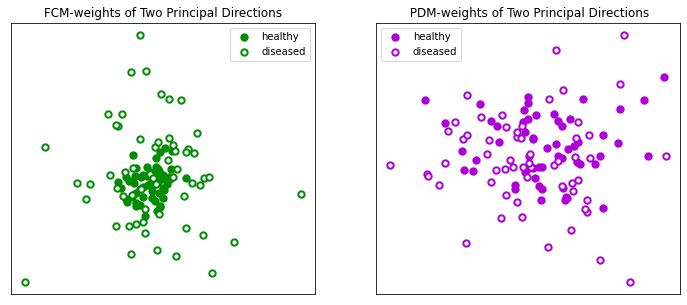

In [4]:
[pW1, pW2] = [10, 15] # eg [0, 1], [10, 15], [0, 114] ...

# split data into healthy and diseased index lists
healthy = np.where(labels == 0)[0]
diseased = np.where(labels != 0)[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data_list = [fcmFeatures, pdmFeatures]
title_list = ['FCM-weights of Two Principal Directions', ' PDM-weights of Two Principal Directions']
legendLocation_list = ['upper right', 'upper left']

for k in range(2):
    ax[k].scatter(data_list[k][pW1, healthy], data_list[k][pW2, healthy], s=40, linewidths=2, c=colors[k], label='healthy')
    ax[k].scatter(data_list[k][pW1, diseased], data_list[k][pW2, diseased], s=40, linewidths=2, c='white', edgecolors=colors[k], label='diseased')
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_title(title_list[k])
    ax[k].legend(loc=legendLocation_list[k])

plt.show()

## Task 5 on Sammon Projection to Two Dimensions

The Sammon projection tries to find a low dimensional (2d in our case) representation of some given high dimensional data, s.t. the following error is minimal

\begin{equation}
Err = \dfrac{1}{\sum_{i<j}d_{R^2}(\text{pr}(\alpha_i), \text{pr}(\alpha_i))} \sum_{i<j}\dfrac{(d_{R^2}(\text{pr}(\alpha_i), \text{pr}(\alpha_i)) - d_{R^d}(\alpha_i, \alpha_j))^2}{d_{R^2}(\text{pr}(\alpha_i), \text{pr}(\alpha_i))}.
\end{equation}

In other words: The distances between two weight vectors $\alpha_i, \alpha_j$ before projection should be close to those after projection.

([A nonlinear mapping for data structure analysis](https://doi.org/10.1109/T-C.1969.222678), JW. Sammon, IEEE Transactions on computers (1969). [PDF](http://syllabus.cs.manchester.ac.uk/pgt/2021/COMP61021/reference/Sammon.pdf))

Sammon projection can also be applied to a subset of the weight vectors, lets say $\{(\alpha_i^{nR_1},\ldots, \alpha_i^{nR_2})\}$. 

Choose different values for `nR1` and `nR2` (values between 0 and 114, `nR1` < `nR2` + 1). What is your impression?
- Are there some weights (subsets of weights) to appear more expressive than others? (w.r.t. disease state)
- If so, what do you think why?
- What can you say about the difference between FCM and PDM?

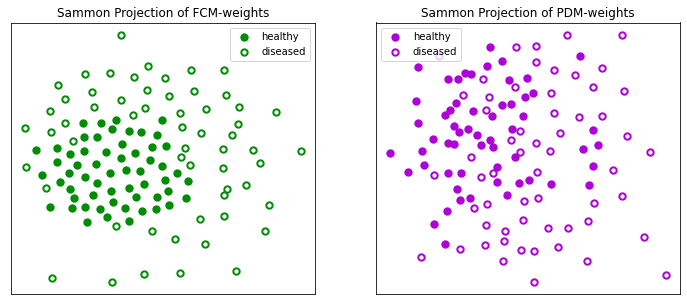

In [5]:
[nR1, nR2] = [0, 114] # e.g. [0, 114] (full range),  [105, 114], etc. 

fcmSammon, _ = sammon(fcmFeatures[nR1:nR2, :].transpose(), 2, display=0)
pdmSammon, _ = sammon(pdmFeatures[nR1:nR2, :].transpose(), 2, display=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data_list = [fcmSammon, pdmSammon]
title_list = ['Sammon Projection of FCM-weights', 'Sammon Projection of PDM-weights']

for k in range(2):
    ax[k].scatter(data_list[k][healthy, 0], data_list[k][healthy, 1], s=40, linewidths=2, c=colors[k], label='healthy')
    ax[k].scatter(data_list[k][diseased, 0], data_list[k][diseased, 1], s=40, linewidths=2, c='white', edgecolors=colors[k], label='diseased')
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_title(title_list[k])
    ax[k].legend(loc=legendLocation_list[k])

plt.show()

# Task 6 on Osteoarthritis Classification Experiment

We emply a linear Support Vector Machine (SVM) trained on the princpal weights of PDM and FCM in order to classify distal femur bones as healthy of diseased w.r.t knee osteoarthritis.

To get a more complete picture we train the SVM on diffrent partitions of the data, e.g. 'nPartitions=9' indicats SVM classifers trained on 10% to 90% (randomly selected elements) of all input data, using the repsective complement as test set. In order to acknowledge the randomess in the experiment design appropriately we repeat the experiment for every partition 'nRandomSamplings' times.

Furthermore, classification can be carried out also on a a subset of the weight vectors, lets say $\{(\alpha_i^{nR_1},\ldots, \alpha_i^{nR_2})\}$. 

The averaged results are plotted together with bars quantifying the standard deviation.

Choose different values for `nR1` and `nR2` (values between 0 and 114, `nR1` < `nR2`). What is your impression?
- Are there some weights (subsets of weights) to appear more expressive than others? (w.r.t. disease state)
- If so, what do you think why?
- What can you say about the difference between FCM and PDM?
- Choose different values for 'nRandomSamplings' (e.g. 10, 100, 1000). Interpret what you see.

Part  1  (9)
Part  2  (9)
Part  3  (9)
Part  4  (9)
Part  5  (9)
Part  6  (9)
Part  7  (9)
Part  8  (9)
Part  9  (9)
Part  1  (9)
Part  2  (9)
Part  3  (9)
Part  4  (9)
Part  5  (9)
Part  6  (9)
Part  7  (9)
Part  8  (9)
Part  9  (9)


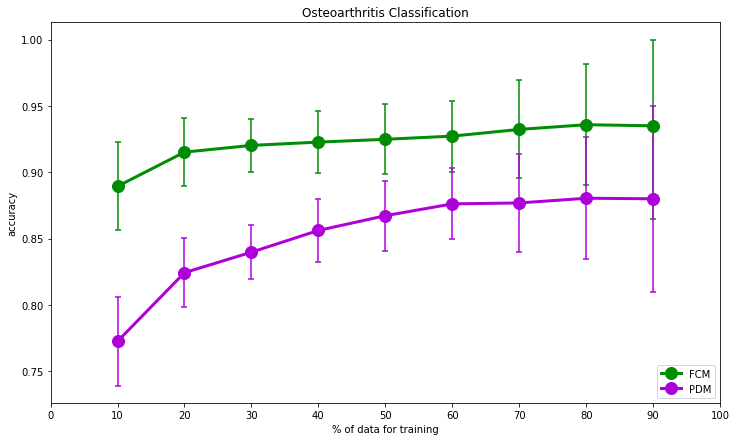

In [2]:
nPartitions = 9
nRandomSamplings = 100

[nR1, nR2] = [0, 114] # e.g. [0, 114] (full range),  [105, 114], etc. 

# normalize feature vectors
fcmFeaturesNorm = normalize(fcmFeatures[nR1:nR2, :], axis=0, norm="l2")
pdmFeaturesNorm = normalize(pdmFeatures[nR1:nR2, :], axis=0, norm="l2")

fcmavgAccuracyPerPartition, fcmstdDevPerPartition = runSVMClassification(nPartitions, nRandomSamplings, fcmFeaturesNorm, labels)
pdmavgAccuracyPerPartition, pdmstdDevPerPartition = runSVMClassification(nPartitions, nRandomSamplings, pdmFeaturesNorm, labels)

data_list_avg = [fcmavgAccuracyPerPartition, pdmavgAccuracyPerPartition]
data_list_std = [fcmstdDevPerPartition, fcmstdDevPerPartition]

plotClassificationResults(data_list_avg, data_list_std, plt, colors)


